## Assessing Combat matrices autism classification using SVM 
- with gridsearch C optimisation
- Support Vector Machine


In [23]:
import pandas as pd
import os
import glob
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, recall_score, precision_score, 
                             roc_auc_score, roc_curve, confusion_matrix, balanced_accuracy_score)



In [24]:
# control_path = '/Users/roshan/Desktop/fMRI/output/combat' #onlt using site as covars
# control_path = '/Users/roshan/Desktop/fMRI/output/autoencoder/'
# # control_path = '/Users/roshan/Desktop/fMRI/output/autoencoder2/'
# control_path = '/Users/roshan/Desktop/fMRI/output/autoencoder3/'
# control_path = '/Users/roshan/Desktop/fMRI/output/autoencoder4/'
# control_path = '/Users/roshan/Desktop/fMRI/output/autoencoder5/'
# control_path = '/Users/roshan/Desktop/fMRI/output/autoencoder6/'
# control_path = '/Users/roshan/Desktop/fMRI/output/autoencoder4_mod/'
# control_path = '/Users/roshan/Desktop/fMRI/output/autoencoder4/'
# control_path = '/Users/roshan/Desktop/fMRI/output/vae1/'
control_path = '/Users/roshan/Desktop/fMRI/output/caae1/'
# control_path = '/Users/roshan/Desktop/fMRI/output/caae1_w_scaling/'
# control_path = '/Users/roshan/Desktop/fMRI/output/caae05/'
# control_path = '/Users/roshan/Desktop/fMRI/output/caae2/'
# control_path = '/Users/roshan/Desktop/fMRI/output/caae5/'

specific_files = glob.glob(os.path.join(control_path, '**', '*.mat'), recursive=True)
patient_files = [f for f in specific_files if 'patient' in f]
control_files = [f for f in specific_files if 'control' in f]

In [25]:
meta_data = pd.read_csv('Sheet 1-ABIDE_metadata.csv')
meta_data.head()

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Site
0,I327154,50002,Autism,M,17,1,fMRI,Resting State fMRI,PITT
1,I328631,50002,Autism,M,17,1,MRI,MP-RAGE,PITT
2,I328256,50003,Autism,M,24,1,fMRI,Resting State fMRI,PITT
3,I328410,50003,Autism,M,24,1,MRI,MP-RAGE,PITT
4,I328736,50004,Autism,M,19,1,MRI,MP-RAGE,PITT


In [26]:

# Initialize lists to hold data and labels
data_matrices = []
labels = []

# Function to load the matrix from a .mat file
def load_matrix(file_path):
    mat_data = loadmat(file_path)
    # Adjust 'data' to the key used in your .mat files
    return mat_data['data']

# Load control data (label = 0)
for file_path in control_files:
    matrix = load_matrix(file_path)
    if matrix is not None:
        data_matrices.append(matrix)
        labels.append(0)  # Label for control

# Load autism data (label = 1)
for file_path in patient_files:
    matrix = load_matrix(file_path)
    if matrix is not None:
        data_matrices.append(matrix)
        labels.append(1)  # Label for autism/patient

# Convert to numpy arrays for further analysis
data_matrices = np.array(data_matrices)
labels = np.array(labels)

# Check the shapes of your loaded data and labels
print("Data matrices shape:", data_matrices.shape)
print("Labels shape:", labels.shape)

Data matrices shape: (198, 116, 116)
Labels shape: (198,)


In [27]:
X = data_matrices.reshape(data_matrices.shape[0], -1)

# Ensure the data is shuffled before splitting
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42, shuffle=True)


In [28]:
# Define the SVM pipeline with scaling
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('svm', SVC(kernel='linear', C=2**-5,probability=True))  # Linear SVM with probability enabled
])

In [19]:
# Define the SVM pipeline with scaling
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the data
    ('svm', SVC(kernel='linear', C=2**-5,probability=True))  # Linear SVM with probability enabled
])
# Train the model using the fixed C value
svm_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_pipeline.predict(X_test)
y_prob = svm_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC calculation

# Since we are not using grid search, there's no need to print the best C value
print("Model trained with fixed C value of 2^-5.")

Model trained with fixed C value of 2^-5.


In [20]:
# takes a minute or two
# # Define the range of C values for grid search: [2^(-5), ..., 2^5]
# param_grid = {
#     'svm__C': [2 ** i for i in range(-7, 3)]  # C values: 2^-5 to 2^5
# }

# # Implement GridSearchCV for cross-validation and hyperparameter tuning
# grid_search = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# # Train the model using grid search
# grid_search.fit(X_train, y_train)

# best_model = grid_search.best_estimator_

# y_pred = best_model.predict(X_test)
# y_prob = best_model.predict_proba(X_test)[:, 1]  #

# print(f"Best C value from Grid Search: {grid_search.best_params_['svm__C']}")


In [21]:
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)  # Sensitivity is the same as recall for the positive class
specificity = recall_score(y_test, y_pred, pos_label=0)  # Sensitivity for the negative class (specificity)
balanced_acc = balanced_accuracy_score(y_test, y_pred)
ppv = precision_score(y_test, y_pred)  # Positive Predictive Value (Precision)
npv = precision_score(y_test, y_pred, pos_label=0)  # Negative Predictive Value (Precision for class 0)
roc_auc = roc_auc_score(y_test, y_prob)

# Display the results
print(f"Classification Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall for positive class): {sensitivity:.3f}")
print(f"Specificity (Recall for negative class): {specificity:.3f}")
print(f"Balanced Accuracy: {balanced_acc:.3f}")
print(f"Positive Predictive Value (PPV): {ppv:.3f}")
print(f"Negative Predictive Value (NPV): {npv:.3f}")
print(f"Area Under ROC Curve (AUC): {roc_auc:.3f}")
# print(f"Accuracy: {accuracy:.2f}")
print('---------------')
print("Classification Report:\n", classification_report(y_test, y_pred))


Classification Accuracy: 0.7000
Sensitivity (Recall for positive class): 0.476
Specificity (Recall for negative class): 0.947
Balanced Accuracy: 0.712
Positive Predictive Value (PPV): 0.909
Negative Predictive Value (NPV): 0.621
Area Under ROC Curve (AUC): 0.742
---------------
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.95      0.75        19
           1       0.91      0.48      0.62        21

    accuracy                           0.70        40
   macro avg       0.76      0.71      0.69        40
weighted avg       0.77      0.70      0.68        40



In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, balanced_accuracy_score, precision_score, roc_auc_score, classification_report

# Assuming y_test and y_pred are already defined
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[18  1]
 [11 10]]


Confusion Matrix:
[[TN, FP],
 [FN, TP]]

In [11]:
import csv

# Define the output file path
output_csv = control_path+'/evaluation_metrics.csv'

# Prepare the data to be written to CSV
metrics = [
    ['Metric', 'Value'],
    ['Classification Accuracy', f'{accuracy:.4f}'],
    ['Sensitivity (Recall for positive class)', f'{sensitivity:.3f}'],
    ['Specificity (Recall for negative class)', f'{specificity:.3f}'],
    ['Balanced Accuracy', f'{balanced_acc:.3f}'],
    ['Positive Predictive Value (PPV)', f'{ppv:.3f}'],
    ['Negative Predictive Value (NPV)', f'{npv:.3f}'],
    ['Area Under ROC Curve (AUC)', f'{roc_auc:.3f}'],
]

# Add the classification report to the CSV
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
metrics.append(['---', '---'])  # Separator row

# Add the per-class metrics to the CSV
for label, metrics_dict in classification_report_dict.items():
    if isinstance(metrics_dict, dict):
        metrics.append([f'{label} - Precision', f'{metrics_dict["precision"]:.3f}'])
        metrics.append([f'{label} - Recall', f'{metrics_dict["recall"]:.3f}'])
        metrics.append([f'{label} - F1-Score', f'{metrics_dict["f1-score"]:.3f}'])
        metrics.append([f'{label} - Support', f'{metrics_dict["support"]}'])

metrics.append(['---', '---'])  # Separator row
metrics.append(['Overall Accuracy', f'{classification_report_dict["accuracy"]:.3f}'])
metrics.append(['Macro Avg - Precision', f'{classification_report_dict["macro avg"]["precision"]:.3f}'])
metrics.append(['Macro Avg - Recall', f'{classification_report_dict["macro avg"]["recall"]:.3f}'])
metrics.append(['Macro Avg - F1-Score', f'{classification_report_dict["macro avg"]["f1-score"]:.3f}'])
metrics.append(['Weighted Avg - Precision', f'{classification_report_dict["weighted avg"]["precision"]:.3f}'])
metrics.append(['Weighted Avg - Recall', f'{classification_report_dict["weighted avg"]["recall"]:.3f}'])
metrics.append(['Weighted Avg - F1-Score', f'{classification_report_dict["weighted avg"]["f1-score"]:.3f}'])

# Write the metrics to a CSV file
with open(output_csv, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(metrics)

print(f"Evaluation metrics saved to {output_csv}")


Evaluation metrics saved to /Users/roshan/Desktop/fMRI/output/caae1_w_scaling//evaluation_metrics.csv


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

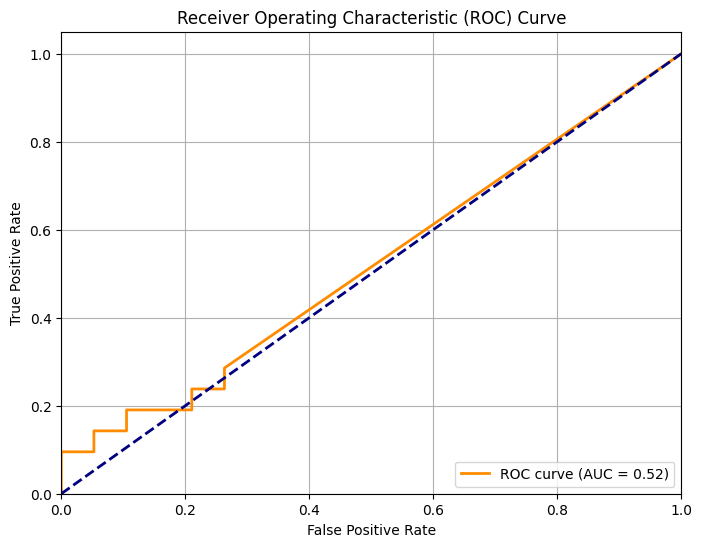

In [12]:
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
